# 数据集提取

In [81]:
#训练集基本参数
trainingfile = 'training_screened_int.xlsx' #训练集文件夹名称
categorical_file = 'agesex.xlsx' #分类文件名称

#数据集拆分初始值
Dataset = {'20':[[88,91,161],[26,12,48],'pos3'],'42':[[84,84,172],[30,19,37],'pos2'],\
           '88':[[90,79,171],[24,24,38],'pos5'],'100':[[94,81,165],[20,22,44],'pos4']}
rdms = list(Dataset.keys())[1]
group_num,blind_num,route = Dataset[rdms][0],Dataset[rdms][1],Dataset[rdms][2]

#输出数据类型
out_dimension = 3
group_name = ['control','mp','dp']

#训练集拆分参数
train_size = 0.8

#测试集参数设置
testing = 'prediction' #盲样文件夹名称
tolerance = 0.5 #质谱峰分辨率选择，不要改动，经测试0.5比0.3好！

#数据集路径
pathL = 'D:\\python test\\project83\\final\\'+route+'\\training_store\\'
pathP = 'D:\\python test\\project83\\final\\'+route+'\\'+testing+'\\'
pathS = 'D:\\python test\\project83\\final\\'+route+'\\'+testing+'_store\\'

# 自定义函数1：pyopenms质核比对齐

In [82]:
import torch
import numpy as np
import pyopenms as oms
from scipy import signal

# 设置随机种子
torch.manual_seed(50)
if torch.cuda.is_available():
    torch.cuda.manual_seed(50)
    torch.backends.cudnn.deterministic = True

#数据质控，质谱峰去噪，去平头峰
def noise_removal(mass_list,tolerance=0.5):
    total = mass_list.values.tolist()
    ref_total = total[1:]+[[0,0]]
    new_total = [[r[0]-m[0],r[1]-m[1]] for r,m in zip(ref_total,total)]   
    tf = [total[0]]
    for new,ref,to in zip(new_total,ref_total,total):
        if new[0] >= tolerance:        
            tf = tf+[ref]
        else:
            if new[1]>=0:                      
                tf = tf[:-1]+[ref]+[ref]
            else:
                tf = tf[:-1]+[to]+[to]
    tf = [m for i,m in enumerate(tf) if m not in tf[:i]]            
    return tf

#生成openms数据格式
def openms_data_format(mass,intensity,decimal=5):
    #质谱保留
    mz = np.round(mass.values,decimal)
    mz_intensity = intensity.values
    spectrum = oms.MSSpectrum()
    spectrum.set_peaks([mz,mz_intensity])
    spectrum.sortByPosition()
    return spectrum

#质量数对齐
def mass_align(ref_spectrum,obs_spectrum,tolerance=0.5):
    alignment = []
    spa = oms.SpectrumAlignment()
    p = spa.getParameters()
    # use 0.5 Da tolerance (Note: for high-resolution data we could also 
    # use ppm by setting the is_relative_tolerance value to true)
    p.setValue("tolerance", tolerance)
    p.setValue("is_relative_tolerance", "false")
    spa.setParameters(p)
    # align both spectra
    spa.getSpectrumAlignment(alignment, ref_spectrum, obs_spectrum)
    return alignment

#取质量数平均值_1
def mass_calculation(re_spectrum,ob_spectrum,alignment,decimal=4):   
    ref = [i[0] for i in alignment]
    obs = [j[1] for j in alignment]
    ref_mass = [re_spectrum.mass[i] for i in ref]
    obs_mass = [ob_spectrum.mass[j] for j in obs]
    ave_mass = np.round((np.array(ref_mass)+np.array(obs_mass))/2,decimal)
    for i,j,q in zip(ref,obs,range(len(ave_mass))):
        re_spectrum.iloc[i, 0] = ave_mass[q]
        ob_spectrum.iloc[j, 0] = ave_mass[q]
    return re_spectrum,ob_spectrum

#按参比文件_2
def mass_calculation_ref(re_spectrum,ob_spectrum,alignment,decimal=4):   
    ref = [i[0] for i in alignment]
    obs = [j[1] for j in alignment]
    for i,j in zip(ref,obs):
        ob_spectrum.iloc[j, 0] = re_spectrum.iloc[i, 0]         
    return re_spectrum,ob_spectrum

#从插值后的数据numpy变成dataframe
def transformed_to_pandas(transformed,train_name,masslist):   
    train_dict = {key: value for key,value in zip(train_name,transformed)}
    train_internal = pd.DataFrame(train_dict).T
    train_internal.reset_index(inplace=True)
    train_internal.columns = ['mass'] + masslist
    return train_internal

# 训练集和测试集生成

In [83]:
import os
import numpy as np
import pandas as pd
from natsort import natsorted

# ——————————训练集——————————
thyroid_train = pd.read_excel(pathL+trainingfile)

# 生成训练集数据y_data和n_train
train_label = [((np.ones(value))*index).tolist() if index > 0 else np.zeros(value).tolist() for index,value in enumerate(group_num)]
train_target = np.array(sum(train_label,[]))
n_train = sum(group_num)

#考核集文件名提取
name_list = natsorted(os.listdir(pathP))
col_list = [fst.split('.')[0] for fst in name_list]

# ——————————测试集——————————
#参比文件
prim = thyroid_train.iloc[:,0:2]

#训练集生成20230922
for name,col in zip(name_list,col_list):
    #读取文件
    indata = pd.read_excel(pathP+name, engine='openpyxl') 
    denoise = noise_removal(indata,tolerance)# 去除噪声
    framefile = pd.DataFrame(denoise,columns=['mass',col])
    
    #数据验证
    ref_spectrum = openms_data_format(prim.mass,prim.iloc[:,1])
    obs_spectrum = openms_data_format(framefile.mass,framefile.iloc[:,1])
    alignment = mass_align(ref_spectrum,obs_spectrum,tolerance)    
    
    #数据整合
    r_spectrum,o_spectrum = mass_calculation_ref(prim,framefile,alignment)
    prim = pd.merge(prim,o_spectrum,how='left',on='mass')#merge用好太不容易了
    
prediction = prim.drop(prim.columns[1], axis=1)
X_pred = prediction.drop('mass',axis=1).values.T
X_pre = np.where(X_pred==0,np.nan,X_pred)
prediction.to_excel(pathS+'prediction.xlsx',index=False)

#测试集读取
blind_target = [((np.ones(value))*index).tolist() if index > 0 else np.zeros(value).tolist() for index,value in enumerate(blind_num)]
blind_target = np.array(sum(blind_target,[]))
prediction_modified = prediction.iloc[:,1:].T.reset_index()
prediction_modified.columns = ['mass']+prediction.mass.tolist()
prediction_modified['target'] = blind_target
prediction_modified.to_excel(pathS+'prediction_modified.xlsx',index=False)
thyroid_blind = pd.read_excel(pathS+'prediction_modified.xlsx')

# 数据预处理：缺失值插补、标准缩放、归一化和生成tensor

In [84]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn.model_selection import train_test_split

# 去掉normalization在LSTM种加入layernormalization_2025.1102
# -----------------------------------------------训练集和测试集数据生成-----------------------------------------------------
train_data = thyroid_train.copy().iloc[:,1:n_train+1].T
blind_data = thyroid_blind.copy().drop(['mass','target'],axis=1)

#-------------------------------------------------缺失值插补和标准化--------------------------------------------------------
makepip = make_pipeline(SimpleImputer(missing_values=np.nan,strategy='median'),StandardScaler(),)
treat = makepip.fit(train_data)
train_normed, blind_normed = treat.transform(train_data), treat.transform(blind_data)

#分类标签生成
mzlist = thyroid_train.mass.tolist()
numerical_cols = [str(i) for i in mzlist]
train_categorical_data = pd.read_excel(pathL+categorical_file)
blind_categorical_data = pd.read_excel(pathS+categorical_file)

# 创建序列样本，用dataloader创建批处理数据

In [85]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')
#年龄和分类数据转换为tensors
#年龄变为tensor
#def one_to_multi(arr):
#arr_multi = np.array([[arr[i]] for i in range(0, len(arr))])
#return arr_multi
#一维数组转置的默认方法.reshape(-1, 1)，注意一维数组.shape返回数组的长度

def age_to_bucket(ages,buckets=[0,20,40,60,80]):
    age_bucket = np.digitize(ages, buckets, right=False) - 1
    ages_multi = age_bucket.reshape(-1, 1)
    return ages_multi

#数据复合数据组合
def data_to_combination(numerical_data,categorical_data):
    #训练集数值分类和年龄数据转换为tensor   
    ages = age_to_bucket(categorical_data['age'].values)  
    categoricals = pd.get_dummies(categorical_data['sex']).values.astype('float32')
    totals = np.hstack((numerical_data,ages.astype('float32'),categoricals))
    return totals

#数据重整
train_total = data_to_combination(train_normed,train_categorical_data)
test_total = data_to_combination(blind_normed,blind_categorical_data)

#转化为tensor
train_tensor,train_target = torch.tensor(train_total,dtype=torch.float32),torch.tensor(train_target,dtype=torch.long)
test_tensor,test_target = torch.tensor(test_total,dtype=torch.float32),torch.tensor(blind_target,dtype=torch.long)

# 数据集划分
X_train, X_val, y_train, y_val = train_test_split(train_tensor,train_target,train_size=train_size,random_state=42)

# 创建序列样本
SEQ_LENGTH = 3 # 输入序列长度
SEQ_SIZE = int(X_train.shape[1]/SEQ_LENGTH)
BATCH_SIZE = 32

# 创建训练集Dataloader
train_dataset = torch.utils.data.TensorDataset(X_train.view(-1,SEQ_LENGTH,SEQ_SIZE), y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 自定义函数2：液态神经网络LNN

In [86]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

class LiquidNeuron(nn.Module):
    """液态神经元模块"""
    def __init__(self, input_size, hidden_size, time_constant=0.1):
        super(LiquidNeuron, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.time_constant = time_constant
        
        # 输入权重
        self.w_input = nn.Linear(input_size, hidden_size)
        
        # 递归连接权重
        self.w_recurrent = nn.Linear(hidden_size, hidden_size, bias=False)
        
        # 时间演化参数
        self.alpha = nn.Parameter(torch.tensor(time_constant))
        
        # 激活函数
        self.activation = nn.Tanh()
        
    def forward(self, x, hidden_state=None):
        batch_size, seq_len, _ = x.size()
        
        if hidden_state is None:
            hidden_state = torch.zeros(batch_size, self.hidden_size).to(x.device)
        
        # 存储所有时间步的隐藏状态
        hidden_states = []
        
        for t in range(seq_len):
            # 输入转换
            input_transformed = self.w_input(x[:, t, :])
            
            # 递归连接
            recurrent = self.w_recurrent(hidden_state)
            
            # 神经元动态更新
            hidden_state = (1 - self.alpha) * hidden_state + self.alpha * self.activation(input_transformed + recurrent)
            
            hidden_states.append(hidden_state.unsqueeze(1))
        
        # 拼接所有时间步的隐藏状态
        output = torch.cat(hidden_states, dim=1)
        return output, hidden_state   
    
class LiquidNeuralNetwork(nn.Module):
    """液态神经网络"""
    def __init__(self, input_size, hidden_size, num_classes, num_liquid_layers=2):
        super(LiquidNeuralNetwork, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        self.layer_norm = nn.LayerNorm(input_size)
        
        # 液态层
        self.liquid_layers = nn.ModuleList()
        for i in range(num_liquid_layers):
            if i == 0:
                layer_input_size = input_size
            else:
                layer_input_size = hidden_size
            self.liquid_layers.append(LiquidNeuron(layer_input_size, hidden_size))
        
        # 输出层
        self.classifier = nn.Sequential(nn.Linear(hidden_size,128),nn.ReLU(),nn.Dropout(0.3),nn.Linear(128, num_classes))
        
    def forward(self, x):
        # 输入x的形状: [batch_size, 1, 28, 28]
        batch_size = x.size(0)
        #x = self.layer_norm(x)
               
        # 通过液态层
        hidden_state = None
        for layer in self.liquid_layers:
            x, hidden_state = layer(x, hidden_state)
        
        # 使用最后一个时间步的输出进行分类
        last_output = x[:, -1, :]
        output = self.classifier(last_output)
        return output,self.liquid_layers

# 模型评估（验证+测试/盲样）
def evaluate_model(model,X_val_seq,valY):
    model.eval()  # 设置模型为评估模式
    
    with torch.no_grad():  # 关闭梯度计算
        outputs,_ = model(X_val_seq)
        _, val_pred = torch.max(outputs, 1)
        val_loss = criterion(outputs, valY).item()
        val_accuracy = (val_pred == valY).sum().item() / len(valY)
        
    return val_pred,(val_loss, val_accuracy)

# 深度学习模型建立

In [87]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, silhouette_score
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# 配置参数
HIDDEN_SIZE = 96 # 隐藏层维度  
INPUT_SIZE = train_dataset[0][0].shape[1]#SEQ_SIZE
NUM_LAYER = 2
NUM_CLASS = 3
EPOCHS = 50         
LR = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# 初始化模型与优化器
model = LiquidNeuralNetwork(input_size=INPUT_SIZE,hidden_size=HIDDEN_SIZE,\
                      num_classes=NUM_CLASS,num_liquid_layers=NUM_LAYER,).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 定义损失函数和优化器
#criterion = nn.MSELoss()  # 回归任务使用均方误差
criterion = nn.CrossEntropyLoss()
 
# 训练初始化参数
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

for epoch in range(EPOCHS):
    #模型初始化参数
    model.train()
    train_loss = 0
    train_num = 0
    accuracy_num = 0
    for trainX, trainY in train_loader:
        trainX, trainY = trainX.to(DEVICE), trainY.to(DEVICE)
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        predictions,layers = model(trainX)
        loss = criterion(predictions, trainY)
        
        # 反向传播与优化
        loss.backward()
        
        # 梯度裁剪（防止梯度爆炸）
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)        
        optimizer.step()
        
        #训练损失和训练准确性
        train_loss += loss.item()  # 累加总损失        
        _, train_pred = torch.max(predictions, 1) 
        train_num += len(trainY)
        accuracy_num += (train_pred == trainY).sum().item()        
        #.item()将仅包含一个元素的张量（即标量张量）转换为对应的 Python 原生数据类型（float, int, 等）
        #.tolist()将仅包含一个或者多个元素的张量转换为对应的 Python 原生数据类型（float, int, 等)        
              
    # 计算每个epoch的训练损失和准确率
    train_loss /= len(train_loader)
    train_accuracy = accuracy_num/train_num
    train_loss_history.append(train_loss)
    train_accuracy_history.append(train_accuracy)
  
    # 计算每个epoch的验证损失和准确率  
    #如果模型中有 BN 层（Batch Normalization）和 Dropout，在测试时添加 model.eval( )。model.eval( ) 是保证 
    #BN 层能够用全部训练数据的均值和方差，即测试过程中要保证 BN 层的均值和方差不变。
    #对于 Dropout，model.eval( ) 是利用到了所有网络连接，即不进行随机舍弃神经元。
    
    X_val_seq = X_val.view(-1,SEQ_LENGTH,SEQ_SIZE).to(DEVICE)
    valY = y_val.to(DEVICE)
    _,(val_loss,val_accuracy) = evaluate_model(model,X_val_seq,valY)
    val_loss_history.append(val_loss)
    val_accuracy_history.append(val_accuracy)    
    
    # 打印训练日志
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}],-Loss: {train_loss:.3f},\
        -Accuracy:{train_accuracy:.3f},-Validation Loss: {val_loss:.3f},\
        -Validation Accuracy:{val_accuracy:.3f}')        

Epoch [2/50],-Loss: 0.880,        -Accuracy:0.654,-Validation Loss: 0.862,        -Validation Accuracy:0.574
Epoch [4/50],-Loss: 0.768,        -Accuracy:0.658,-Validation Loss: 0.821,        -Validation Accuracy:0.574
Epoch [6/50],-Loss: 0.738,        -Accuracy:0.673,-Validation Loss: 0.792,        -Validation Accuracy:0.603
Epoch [8/50],-Loss: 0.700,        -Accuracy:0.717,-Validation Loss: 0.742,        -Validation Accuracy:0.706
Epoch [10/50],-Loss: 0.614,        -Accuracy:0.783,-Validation Loss: 0.634,        -Validation Accuracy:0.750
Epoch [12/50],-Loss: 0.468,        -Accuracy:0.835,-Validation Loss: 0.393,        -Validation Accuracy:0.897
Epoch [14/50],-Loss: 0.359,        -Accuracy:0.871,-Validation Loss: 0.287,        -Validation Accuracy:0.912
Epoch [16/50],-Loss: 0.317,        -Accuracy:0.882,-Validation Loss: 0.254,        -Validation Accuracy:0.912
Epoch [18/50],-Loss: 0.283,        -Accuracy:0.879,-Validation Loss: 0.273,        -Validation Accuracy:0.926
Epoch [20/50],

# Plotting the training and validation loss

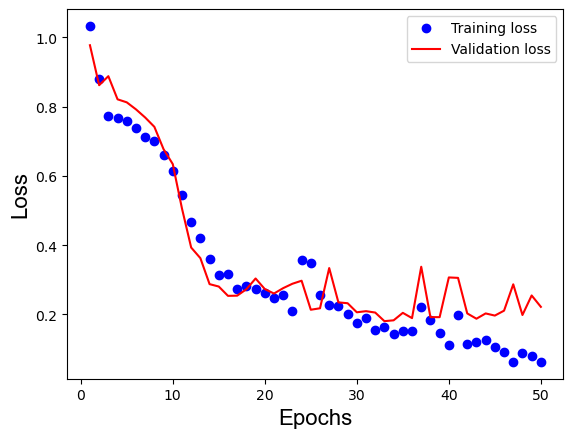

In [88]:
import matplotlib.pyplot as plt
loss_values = train_loss_history
val_loss_values = val_loss_history
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "r", label="Validation loss")
#plt.title("Training and validation loss")
plt.xlabel("Epochs",font={'family':'Arial', 'size':16})
plt.ylabel("Loss",font={'family':'Arial', 'size':16})
plt.legend()
plt.savefig(pathL+'Train_vali_loss_lnn.jpg',dpi=300, bbox_inches='tight')
plt.show()
#plt.close()

# Plotting the training and validation accuracy

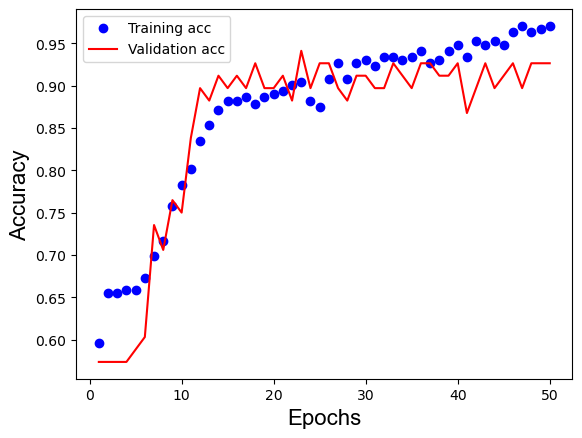

In [89]:
plt.clf()
acc = train_accuracy_history
val_acc = val_accuracy_history
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "r", label="Validation acc")
#plt.title("Training and validation accuracy")
plt.xlabel("Epochs",font={'family':'Arial', 'size':16})
plt.ylabel("Accuracy",font={'family':'Arial', 'size':16})
plt.legend()
plt.savefig(pathL+'Train_vali_accuracy_lnn.jpg',dpi=300, bbox_inches='tight')
plt.show()
#plt.close()

# 模型评估、保存、考核集预测

0.919


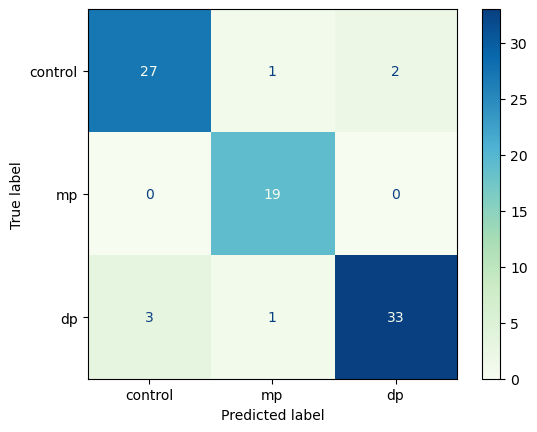

In [90]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# 保存整个模型
torch.save(model, 'PDD_LNN_'+rdms+'_model.pth')
trained_model = torch.load('PDD_LNN_'+rdms+'_model.pth')

# Evaluate the model
test_seq = test_tensor.view(-1,SEQ_LENGTH,SEQ_SIZE).to(DEVICE)
testY = test_target.to(DEVICE)
test_pred,(_,test_accuracy) = evaluate_model(trained_model,test_seq,testY)
test_target = testY.cpu()
test_pred = test_pred.cpu()

# 混淆矩阵
target_names = group_name
conf_mat=confusion_matrix(test_target,test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=target_names)
disp.plot(cmap="GnBu")#coolwarm_r,GnBu
#plt.title('Confusion matrix')
plt.savefig(pathS+'_confusion matrix_lnn.jpg',dpi=300, bbox_inches='tight')

#分类报告
classification_report = classification_report(test_target, test_pred, 
                                              target_names=target_names, output_dict=True)
df = pd.DataFrame(classification_report).transpose()
df.to_csv(pathS+'Classification_report_LNN_'+rdms+'_result.csv', index= True)
print(round(test_accuracy,3))

# 创建一个映射，将索引映射到类别标签
label_map = {index: value for index, value in enumerate(group_name)}
 
# 将索引映射到类别标签
pred_labels = [label_map[idx] for idx in test_pred.tolist()]
pre_data_name = thyroid_blind.mass
Data_store = pd.DataFrame(np.c_[pre_data_name,pred_labels],columns=['SAMPLE','PREDICTION'])
Data_store.to_csv(pathS+'Pytorch_LNN_PDD_'+rdms+'_test_result.csv',sep=',',index=False)